In [ ]:
### INSTALL PACKAGES IF NEEDED
!pip install pandas-datareader
!pip install arch

In [ ]:
pip install pandas openpyxl

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import t
import pandas_datareader.data as web

## Step 1: Load Stock Price Data and Merge with Bitcoin Data

In [2]:
df1 = pd.read_excel(r"C:\Users\sarah\Desktop\BC\Fall 2025\MESA8414 Applied AI and Machine Learning\Time Series Project\Time Series Project Dataset-1.xlsx", sheet_name="Daily Data", usecols=["Date", "SPY Price"])
df2 = pd.read_csv(r"C:\Users\sarah\Desktop\BC\Fall 2025\MESA8414 Applied AI and Machine Learning\Time Series Project\Bitcoin_history_data.csv", usecols=["Date", "Close"])

# Convert both Date columns to the same datetime format
df1['Date'] = pd.to_datetime(df1['Date'])
df2['Date'] = pd.to_datetime(df2['Date'])

merged = pd.merge(df1, df2, on="Date")
print(merged.head())

        Date  SPY Price       Close
0 2015-09-08     197.43  243.606995
1 2015-09-09     194.79  238.167999
2 2015-09-10     195.85  238.477005
3 2015-09-11     196.74  240.106995
4 2015-09-14     196.01  230.643997


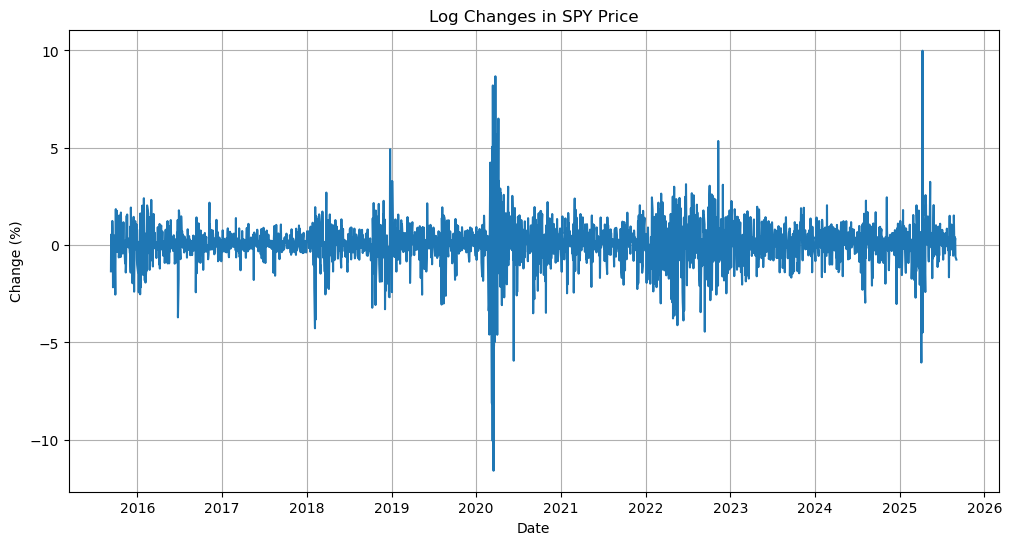

In [9]:
# Compute log changes
merged['Change_SPY'] = np.log(merged['SPY Price'] / merged['SPY Price'].shift(1)) * 100 
returns = merged[['Date', 'Change_SPY']].dropna()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(returns['Date'], returns['Change_SPY'])
plt.title('Log Changes in SPY Price')
plt.xlabel('Date')
plt.ylabel('Change (%)')
plt.grid(True)
plt.show()



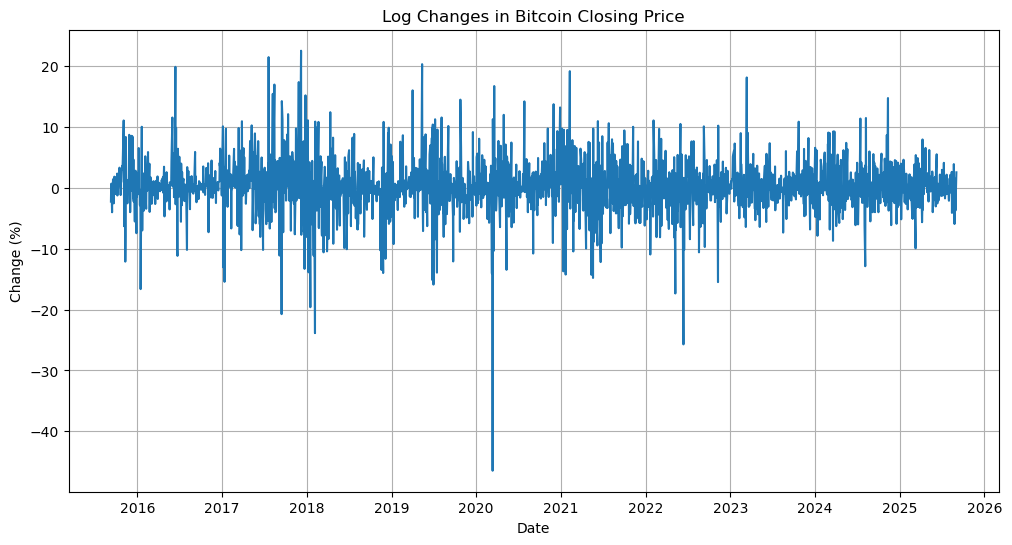

In [10]:
# Compute log changes
merged['Change_Bitcoin'] = np.log(merged['Close'] / merged['Close'].shift(1)) * 100 
returns = merged[['Date', 'Change_Bitcoin']].dropna()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(returns['Date'], returns['Change_Bitcoin'])
plt.title('Log Changes in Bitcoin Closing Price')
plt.xlabel('Date')
plt.ylabel('Change (%)')
plt.grid(True)
plt.show()

## Step 2: Fit GARCH(1,1) Model 

In [31]:
y = merged['Change_SPY'].dropna()
X = merged[['Change_Bitcoin']].loc[y.index]  # align predictor with y

model1 = arch_model(y, x=X, vol='Garch', p=1, q=1, mean='ARX', dist='normal')
res1 = model1.fit(disp='off')
print(res1.summary()) 

                          AR-X - GARCH Model Results                          
Dep. Variable:             Change_SPY   R-squared:                       0.028
Mean Model:                      AR-X   Adj. R-squared:                  0.027
Vol Model:                      GARCH   Log-Likelihood:               -3252.08
Distribution:                  Normal   AIC:                           6514.17
Method:            Maximum Likelihood   BIC:                           6543.31
                                        No. Observations:                 2510
Date:                Thu, Sep 18 2025   Df Residuals:                     2508
Time:                        15:24:10   Df Model:                            2
                                   Mean Model                                   
                     coef    std err          t      P>|t|      95.0% Conf. Int.
--------------------------------------------------------------------------------
Const              0.0755  1.526e-02      4.94

## Step 3: FIt EGARCH(1,1) Model

In [32]:
model2 = arch_model(y, x=X, vol='EGARCH', p=1, q=1,
                    mean='ARX', dist='normal')
res2 = model2.fit(disp='off')
print(res2.summary())

                         AR-X - EGARCH Model Results                          
Dep. Variable:             Change_SPY   R-squared:                       0.023
Mean Model:                      AR-X   Adj. R-squared:                  0.023
Vol Model:                     EGARCH   Log-Likelihood:               -3262.57
Distribution:                  Normal   AIC:                           6535.14
Method:            Maximum Likelihood   BIC:                           6564.28
                                        No. Observations:                 2510
Date:                Thu, Sep 18 2025   Df Residuals:                     2508
Time:                        15:24:13   Df Model:                            2
                                   Mean Model                                   
                     coef    std err          t      P>|t|      95.0% Conf. Int.
--------------------------------------------------------------------------------
Const              0.0887  7.555e-04    117.40

## Step 4: Compare AIC/BIC

In [33]:
print("GARCH AIC:", res1.aic, "| BIC:", res1.bic)
print("EGARCH AIC:", res2.aic, "| BIC:", res2.bic)

GARCH AIC: 6514.167545621052 | BIC: 6543.307735781682
EGARCH AIC: 6535.138580540701 | BIC: 6564.27877070133


## Step 5: Residual Diagnostics - ACF

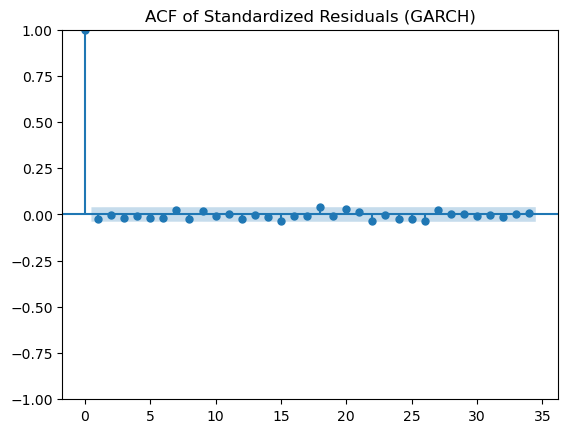

In [34]:
plot_acf(res1.std_resid)
plt.title("ACF of Standardized Residuals (GARCH)") ###GARCH is a better fitting model. 
plt.show()

## Step 5: Ljung-Box Test

In [35]:
lb_test = acorr_ljungbox(res1.std_resid, lags=24, return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
1    1.577100   0.209179
2    1.577428   0.454429
3    2.341560   0.504606
4    2.570620   0.632036
5    3.307522   0.652690
6    4.259737   0.641573
7    5.648465   0.581342
8    7.268426   0.507968
9    7.961971   0.537983
10   8.047288   0.624218
11   8.088856   0.705323
12   9.454472   0.663700
13   9.460016   0.737381
14   9.990576   0.762872
15  13.076263   0.596407
16  13.268559   0.653030
17  13.527814   0.700198
18  17.343221   0.499639
19  17.641090   0.546519
20  20.031768   0.455944
21  20.447127   0.493119
22  23.825671   0.356433
23  23.854504   0.411901
24  25.726641   0.367180


## Step 7: Rolling Forecast (Expanding Window)

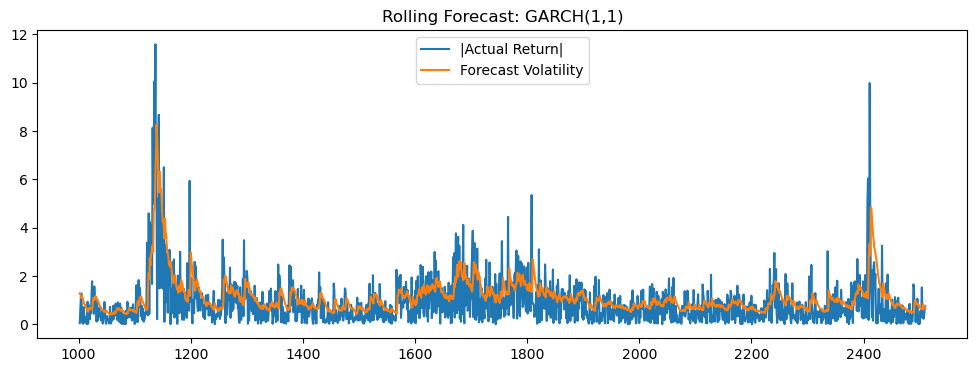

In [39]:
rolling_preds = []
true_vals = []
window = 1000

for i in range(window, len(y) - 1):
    train = y.iloc[:i]
    test = y.iloc[i + 1]

    model = arch_model(train, vol='GARCH', p=1, q=1, mean='ARX', dist='t') 
    result = model.fit(disp='off')
    forecast = result.forecast(horizon=1)
    sigma = np.sqrt(forecast.variance.values[-1, 0])
    rolling_preds.append(sigma)
    true_vals.append(abs(test))
    

plt.figure(figsize=(12, 4))
plt.plot(y.index[window + 1:], true_vals, label="|Actual Return|")
plt.plot(y.index[window + 1:], rolling_preds, label="Forecast Volatility")
plt.legend()
plt.title("Rolling Forecast: GARCH(1,1)")
plt.show()

## Step 8: Dynamic Value at Risk (VaR)

In [41]:
print(res1.params.index)

Index(['Const', 'Change_Bitcoin', 'omega', 'alpha[1]', 'beta[1]'], dtype='object')


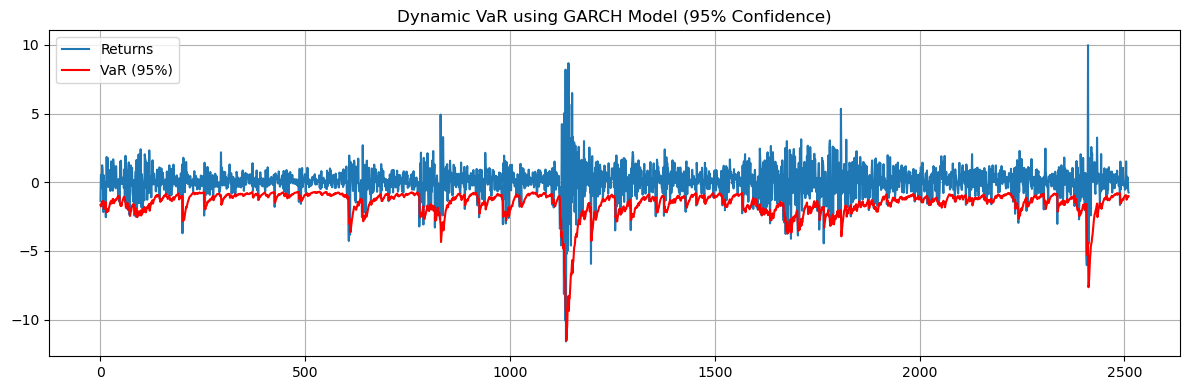

In [43]:
from scipy.stats import norm

alpha = 0.05  
z_alpha = norm.ppf(alpha)

mu = pd.Series(res1.params['Const'], index=y.index)

sigma = res1.conditional_volatility.reindex(y.index)
VaR = mu + sigma * z_alpha

plt.figure(figsize=(12, 4))
plt.plot(y.index, y, label="Returns")
plt.plot(y.index, VaR, label="VaR (95%)", color='red')
plt.title("Dynamic VaR using GARCH Model (95% Confidence)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 9: Fit an ARIMA Model for Forecasting SPY Price

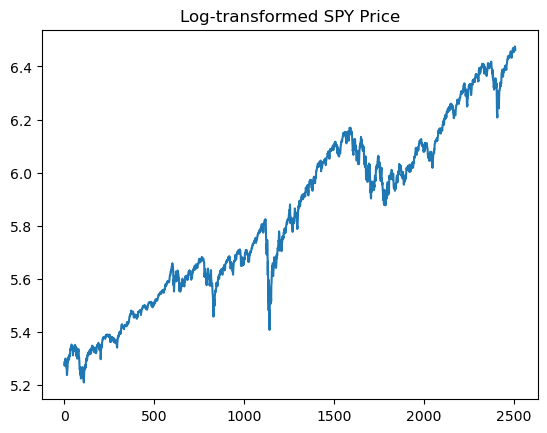

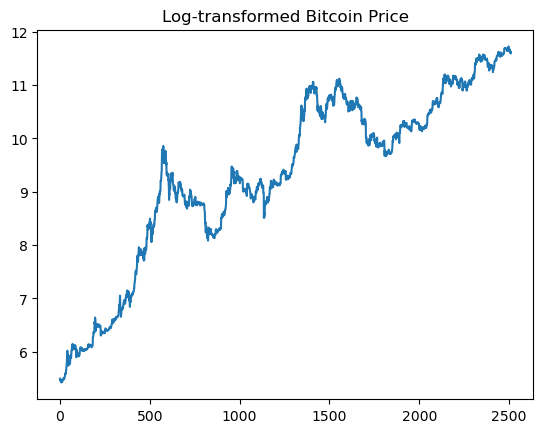

In [59]:
# Log transform
log_spy = np.log(merged["SPY Price"])
log_spy.plot(title='Log-transformed SPY Price')
plt.show()

log_bit = np.log(merged["Close"])
log_bit.plot(title='Log-transformed Bitcoin Price')
plt.show()

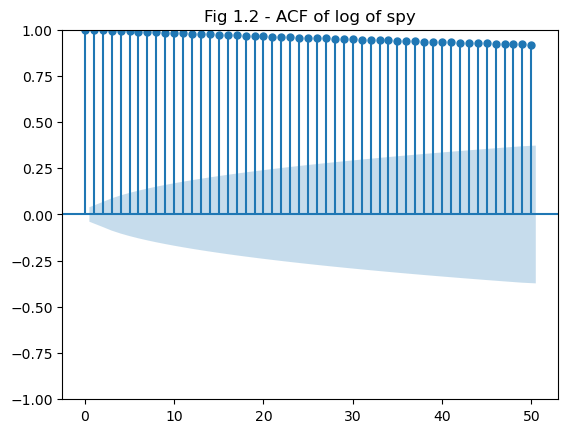

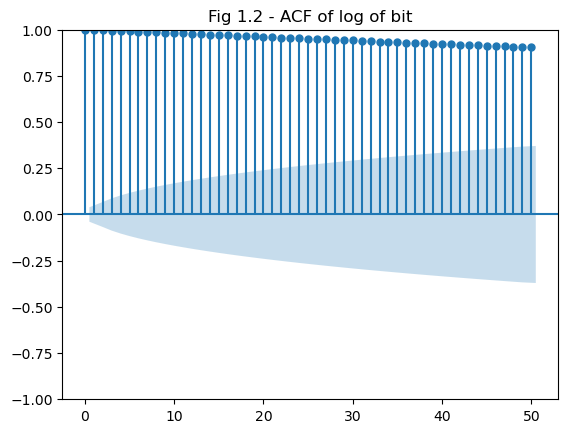

In [62]:
#ACF of log series
from statsmodels.tsa.stattools import acf, pacf, adfuller
acf_values = acf(log_spy, nlags=50, fft=True)
plot_acf(log_spy, lags=50, title="Fig 1.2 - ACF of log of spy")
plt.show()

from statsmodels.tsa.stattools import acf, pacf, adfuller
acf_values = acf(log_bit, nlags=50, fft=True)
plot_acf(log_bit, lags=50, title="Fig 1.2 - ACF of log of bit")
plt.show()

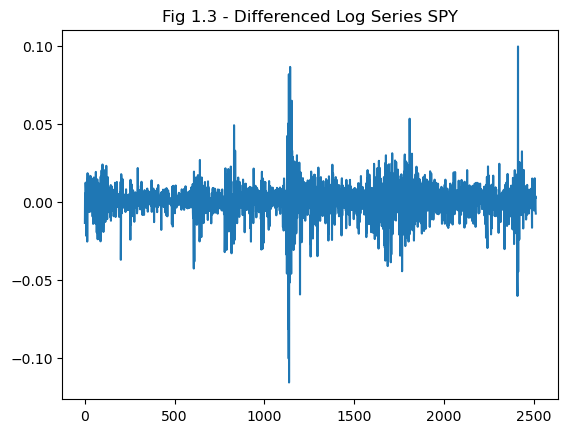

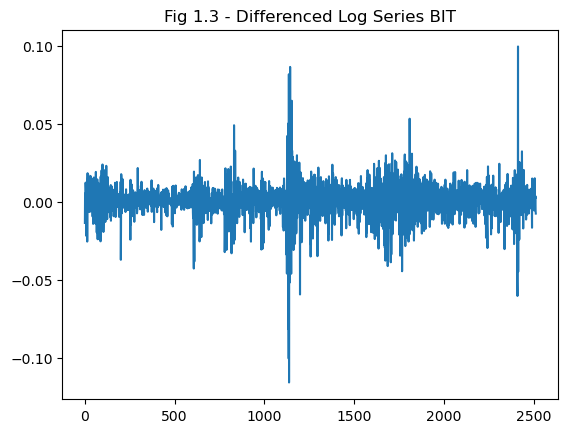

In [63]:
# Differencing
diff_spy = log_spy.diff().dropna()
diff_spy.plot(title='Fig 1.3 - Differenced Log Series SPY')
plt.show()

diff_bit = log_bit.diff().dropna()
diff_spy.plot(title='Fig 1.3 - Differenced Log Series BIT')
plt.show()


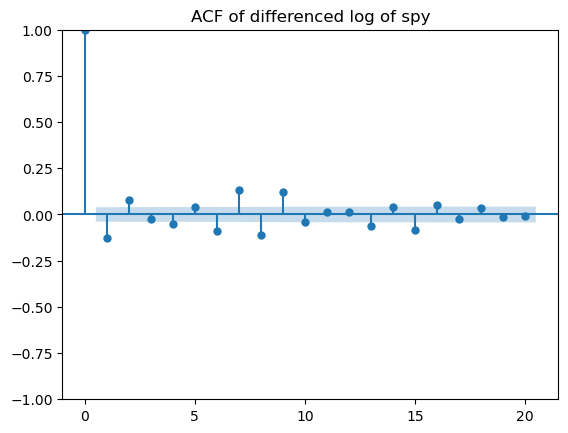

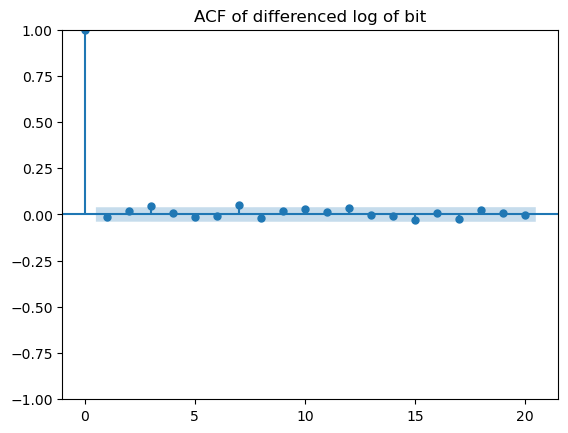

In [65]:
# ACF of differenced log
plot_acf(diff_spy, lags=20)
plt.title('ACF of differenced log of spy')
plt.show()

plot_acf(diff_bit, lags=20)
plt.title('ACF of differenced log of bit')
plt.show()

In [ ]:
model_diff = OLS(diff_spy.values, add_constant(np.arange(len(diff_spy)))).fit()
print(model_diff.summary())

In [67]:

pmax, qmax = 7, 7
aic_matrix = np.full((pmax + 1, qmax + 1), np.nan)
bic_matrix = np.full((pmax + 1, qmax + 1), np.nan)


for p in range(pmax + 1):
    for q in range(qmax + 1):
        try:
            model = ARIMA(y, order=(p, 0, q)).fit()
            aic_matrix[p, q] = model.aic
            bic_matrix[p, q] = model.bic
        except:
            continue

print("AIC Matrix:\n", aic_matrix)
print("BIC Matrix:\n", bic_matrix)

C:\Users\sarah\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\sarah\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\sarah\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\sarah\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sarah\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sar

AIC Matrix:
 [[  1649.23518019  -1850.7642553   -4660.54012233  -7004.8274553
   -8425.85338182  -9913.27956093 -10518.75025435 -11518.37184106]
 [-15960.85901656 -15993.50778325 -16006.08109829 -16005.97718029
  -16005.71600379 -16000.09476043 -16010.42645423 -16030.4389105 ]
 [-15998.2982999  -16002.19665807 -16005.14833379 -15996.05269121
  -15995.20518507 -16033.19600436 -16044.83304294 -16050.67338642]
 [-16006.30681351 -16002.27918748 -16078.26075091 -16080.31575974
  -16078.7938508  -16031.31925377 -16070.58670953 -16050.53594633]
 [-16004.29453158 -16000.00339773 -16035.6811573  -15849.65213731
  -16036.15664422 -16077.52979595 -16084.99804987 -16091.49002559]
 [-16008.27218171 -16008.22579629 -16025.65986344 -16003.76522487
  -16076.23844869 -16061.86572052 -16063.21537357 -16073.42742624]
 [-16007.64074088 -16053.78357474 -16047.0612501  -16032.4634999
  -16052.67394099 -16053.47706207 -16040.98432179 -16082.26488104]
 [-16022.40633861 -16072.06601641 -16024.68890651 -16047.4

C:\Users\sarah\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sarah\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                btc_ret   No. Observations:                 2605
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4577.034
Date:                Thu, 18 Sep 2025   AIC                          -9146.068
Time:                        17:07:18   BIC                          -9122.607
Sample:                    09-09-2015   HQIC                         -9137.568
                         - 09-02-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.839      0.005       0.001       0.004
ar.L1         -0.0032      2.376     -0.001      0.999      -4.660       4.654
ma.L1         -0.0032      2.376     -0.001      0.9

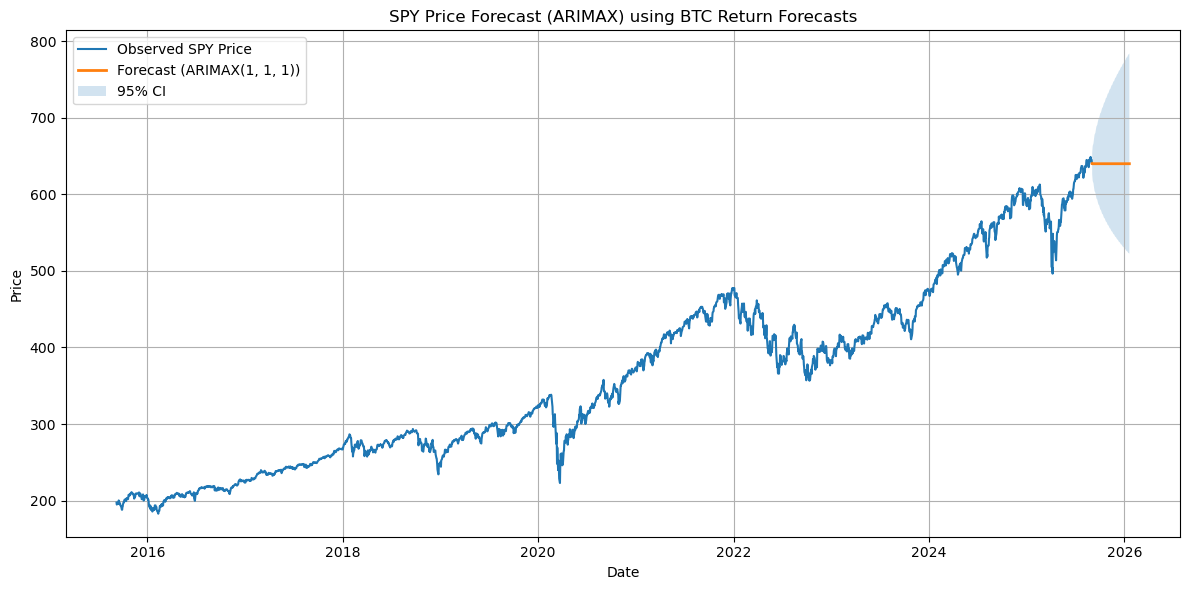

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# =========================
# 0) Config
# =========================
h = 100  # forecast horizon (business days)
spy_col = 'SPY Price'
btc_col = 'Close'  # Bitcoin price column

# =========================
# 1) Clean & align on business days
# =========================
df = merged[['Date', spy_col, btc_col]].copy()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = (df.dropna(subset=['Date'])
        .sort_values('Date')
        .drop_duplicates('Date')
        .set_index('Date')
        .asfreq('B'))  # business-day calendar

# ensure numeric and forward-fill gaps
df[spy_col] = pd.to_numeric(df[spy_col], errors='coerce').ffill()
df[btc_col] = pd.to_numeric(df[btc_col], errors='coerce').ffill()

# avoid log(0)
eps = 1e-8
df[spy_col] = df[spy_col].clip(lower=eps)
df[btc_col] = df[btc_col].clip(lower=eps)

# =========================
# 2) Build endogenous & exogenous
# =========================
log_spy = np.log(df[spy_col])              # will use ARIMA(..., d=1) on this
btc_ret = np.log(df[btc_col]).diff()       # stationary exogenous

# align (diff drops first row)
aligned = pd.concat([log_spy.rename('log_spy'),
                     btc_ret.rename('btc_ret')], axis=1).dropna()
y = aligned['log_spy']
X = aligned[['btc_ret']]

# quick sanity checks
assert np.isfinite(y).all(), "Non-finite values in y"
assert np.isfinite(X.values).all(), "Non-finite values in X"

# =========================
# 3) Model and forecast BTC log-returns (exogenous future)
#    Use a simple ARIMA(1,0,1) on btc_ret
# =========================
btc_model = ARIMA(X['btc_ret'], order=(1, 0, 1)).fit()
print(btc_model.summary())

# Future business-day index
future_idx = pd.date_range(y.index[-1] + pd.offsets.BusinessDay(),
                           periods=h, freq='B')

btc_fc = btc_model.get_forecast(steps=h)
btc_ret_future = pd.Series(btc_fc.predicted_mean, index=future_idx, name='btc_ret')

# sanity
assert btc_ret_future.shape[0] == h
assert np.isfinite(btc_ret_future.values).all(), "Non-finite future BTC returns"

# =========================
# 4) Fit ARIMAX on log(SPY) with exogenous btc_ret
# =========================
order = (1, 1, 1)  # ARIMA(p, d=1, q) on log price
spy_model = ARIMA(y, order=order, exog=X).fit()
print(spy_model.summary())

# =========================
# 5) Forecast SPY price using BTC-return forecasts
# =========================
spy_fc = spy_model.get_forecast(steps=h, exog=btc_ret_future.to_frame())
log_mean = spy_fc.predicted_mean
log_ci = spy_fc.conf_int()

# back-transform to price
price_mean = np.exp(log_mean)
price_ci_lower = np.exp(log_ci.iloc[:, 0])
price_ci_upper = np.exp(log_ci.iloc[:, 1])

# =========================
# 6) Plot
# =========================
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[spy_col], label='Observed SPY Price')
plt.plot(price_mean.index, price_mean, label=f'Forecast (ARIMAX{order})', linewidth=2)
plt.fill_between(price_mean.index, price_ci_lower, price_ci_upper, alpha=0.2, label='95% CI')
plt.title('SPY Price Forecast (ARIMAX) using BTC Return Forecasts')
plt.xlabel('Date'); plt.ylabel('Price'); plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


In [68]:
# fc: result of res.get_forecast(...)
log_mean = fc.predicted_mean
log_ci = fc.conf_int()

# Back-transform from log-price to price
price_mean = np.exp(log_mean)
price_ci_lower = np.exp(log_ci.iloc[:, 0])
price_ci_upper = np.exp(log_ci.iloc[:, 1])

# Build a neat table
forecast_table = pd.DataFrame({
    'Forecast Price': price_mean,
    'Lower 95% CI': price_ci_lower,
    'Upper 95% CI': price_ci_upper
})

# Optional: round for readability
forecast_table = forecast_table.round(2)

# Optional: reset index so Date is a column
forecast_table = forecast_table.reset_index().rename(columns={'index': 'Date'})

print(forecast_table.head(10))   # preview first 10 rows

# Save to CSV if you want
forecast_table.to_csv('spy_price_forecast.csv', index=False)
print("Saved to spy_price_forecast.csv")

        Date  Forecast Price  Lower 95% CI  Upper 95% CI
0 2025-09-03          640.76        627.09        654.73
1 2025-09-04          640.51        622.09        659.48
2 2025-09-05          640.64        618.15        663.95
3 2025-09-08          640.57        614.83        667.40
4 2025-09-09          640.61        611.92        670.64
5 2025-09-10          640.59        609.29        673.50
6 2025-09-11          640.60        606.89        676.18
7 2025-09-12          640.60        604.65        678.67
8 2025-09-15          640.60        602.56        681.03
9 2025-09-16          640.60        600.59        683.27
Saved to spy_price_forecast.csv
